# Work with Connections

**[Connections](https://docs.aperturedata.io/category/connection-commands) are a way to represent [relationships between objects](https://docs.aperturedata.io/concepts/Schema) in ApertureDB like works_at, contains, etc.  They are the edges in the graph.**

## Connect to the database

If you haven't already setup the database or configured it, check out our [quick start guide](https://docs.aperturedata.io/Setup/QuickStart)

In [ ]:
# Install the required client packages if needed
%pip install --upgrade --quiet pip
%pip install --upgrade --quiet aperturedb

In [1]:
from aperturedb.CommonLibrary import create_connector

# Create the connector for ApertureDB
client = create_connector()

## Check connection

A simple query to verify the database connection.  See [GetStatus](https://docs.aperturedata.io/query_language/Reference/db_commands/GetStatus).

In [2]:
query = [{
    "GetStatus": {
    }
}]

# Execute the query to get back a JSON response for GetStatus 
response, blobs = client.query(query)

client.print_last_response()

[
    {
        "GetStatus": {
            "info": "OK",
            "status": 0,
            "system": "ApertureDB",
            "version": "0.17.23"
        }
    }
]


## Connect Dishes to Ingredients — Build a Graph

Let's say we have dishes as images with properties in the database and we want to connect them to their corresponding ingredients represented as entities we added earlier. One way to introduce new connections in the database is through our query language

**For bulk additions, we recommend using the [Python SDK loaders](http://docs.aperturedata.io/category/manage-multimodal-datasets)**

More details about connection commands [here](https://docs.aperturedata.io/category/connection-commands) and about the parameter "connect" [here](https://docs.aperturedata.io/query_language/Reference/shared_command_parameters/connect)

More about graph metadata schema supported in ApertureDB [here](https://docs.aperturedata.io/HowToGuides/start/Schema).

In [3]:
query = [{
    "AddEntity": {
        "_ref": 1,                    # Forward reference to this entity, to be used in subsequent commands in the same query
        "class": "Ingredient",        # Every entity belongs to a class, in this case Ingredient
        "properties": {               # You can define as many key, value properties per entity, as needed
            "name": "butter",         # The data type for "name" property of an Ingredient will now always be of the type "string".
            "macronutrient": "fat",
            "subgroup": "dairy",
            "category": "vegetarian"
        },
        "if_not_found": {             # conditional add on key field; avoid adding twice
            "name": ["==", "butter"] 
        }
    }}, {
    "AddImage": {
        "_ref": 2,                    # Forward reference to this image, to be used in subsequent commands in the same query
        "properties": {
            "name": "Focaccia",
            "id": 35,
            "contributor": "Vishakha",
            "category": "starter",
            "cuisine": "Italian",
            "location": "Brittany",
            "caption": "fresh made focaccia with herbs from the garden"
        },
        "if_not_found": {              # conditional add on key field; avoid adding twice
            "id": ["==", 35]
        }
    }}, {
    "AddConnection": {                 # Now connect the results of the previous two commands using their handles, also see connect:{} parameter
        "class": "ingredient",         # Connections themselves can have classes
        "src": 1,                      # backward reference to 'Ingredient' entity added above
        "dst": 2,                      # backward reference to 'Focaccia' image added above
        "properties": {                # Connections can also have their own set of key,value properties
            "best_image": True
        }
    }
}]

# Read the image data as a binary blob
fd = open("data/focaccia_brittany.jpg", 'rb')
image_arr = [ fd.read() ]
fd.close()

response, blobs = client.query(query, image_arr)

client.print_last_response()

[
    {
        "AddEntity": {
            "status": 0
        }
    },
    {
        "AddImage": {
            "status": 0
        }
    },
    {
        "AddConnection": {
            "status": 0
        }
    }
]


## Read or Query properties of the added Connection

Verify that our "ingredient" connection was added to the database and read all of its property values

In [4]:
query = [{
    "FindConnection": {
        "with_class": "ingredient",               # Every connection belongs to a class, in this case self_image
        "results": {                              # The results object controls what is returned    
            "all_properties": True                # Return all properties of the connection
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "FindConnection": {
            "connections": [
                {
                    "_uniqueid": "25.0.224101",
                    "best_image": true
                }
            ],
            "returned": 1,
            "status": 0
        }
    }
]


## Use the Connection from Ingredient to Traverse (graph) and Find Dish (image)
Queries can use the [is_connected_to](https://docs.aperturedata.io/query_language/Reference/shared_command_parameters/is_connected_to) parameter to traverse connections in the ApertureDB graph.

[
    {
        "FindEntity": {
            "entities": [
                {
                    "category": "vegetarian",
                    "name": "butter"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "FindImage": {
            "blobs_start": 0,
            "entities": [
                {
                    "_blob_index": 0,
                    "id": 35,
                    "name": "Focaccia"
                }
            ],
            "returned": 1,
            "status": 0
        }
    }
]


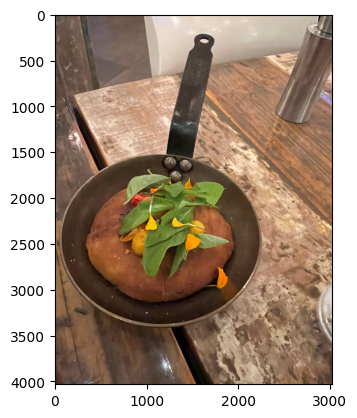

In [5]:
from aperturedb import NotebookHelpers as nh   # Our helper package for image displays and other utilities

query = [{
    "FindEntity": {
        "_ref": 1,                            # Forward reference to this entity, to be used in subsequent commands in the same query
        "with_class": "Ingredient",           # Only look for entities of class 'Ingredient'
        "constraints": {
            "name": ["==", "butter"]          # Only consider entities with the property 'name' equal to 'butter'
        },
        "results": {
            "list": ["name", "category"]       # Retrieve only the properties 'name' and 'category'.
        }
    }}, {
    "FindImage": {
        "is_connected_to": {                   # Look for images that have connections to the entity found above.
            "ref": 1,                          # backward reference to 'Ingredient' entity found above
            "connection_class": "ingredient",  # Only consider connections of the 'ingredient' class
            "constraints": {
                "best_image": ["==", True]     # Only consider connections with the property 'best_image' equal to 'True'
            }
        },
        "blobs": True,                         # Retrieve the image data as a binary blob
        "results": {
            "list": ["name", "id"]             # Retrieve only the properties 'name' and 'id'.
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()
nh.display(blobs)

## Update properties of Connection already in ApertureDB

Use [UpdateConnection](https://docs.aperturedata.io/query_language/Reference/connection_commands/UpdateConnection) if any of the attributes need a new value or your application now needs a new attribute in existing entities

In [6]:
query = [{
    "UpdateConnection": {
        "with_class": "ingredient",     # Find any connections of class 'ingredient' ...
        "constraints": {
            "best_image": ["==", True]  # With the property 'best_image' equal to 'True' ...
        },
        "properties": {
            "best_image": False,        # And update them by setting 'best_image' to 'False'.
        },
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "UpdateConnection": {
            "count": 1,
            "status": 0
        }
    }
]


In [7]:
# Check that the connection was modified
query = [{
    "FindEntity": {
        "_ref": 1,                             # Forward reference to this entity, to be used in subsequent commands in the same query
        "with_class": "Ingredient",            # Only look for entities of class 'Ingredient
        "constraints": {
            "name": ["==", "butter"]           # Only consider entities with the property 'name' equal to 'butter'
        },
        "results": {
            "list": ["name", "category"]       # Retrieve only the properties 'name' and 'category'.
        }
    }}, {
    "FindImage": {
        "is_connected_to": {                   # Look for images that have connections to the entity found above.
            "ref": 1,                          # Backward reference to 'Ingredient' entity found above
            "connection_class": "ingredient",  # Only consider connections of the 'ingredient' class
            "constraints": {
                "best_image": ["==", True]     # Only consider connections with the property 'best_image' equal to 'True'
            }
        },
        "blobs": True,                         # Retrieve the image data as a binary blob 
        "results": {
            "list": ["name", "id"]             # Retrieve only the properties 'name' and 'id'.
        }
    }
}]

response, blobs = client.query(query)

# We expect that this search shouldn't find anything.
client.print_last_response()
nh.display(blobs)

[
    {
        "FindEntity": {
            "entities": [
                {
                    "category": "vegetarian",
                    "name": "butter"
                }
            ],
            "returned": 1,
            "status": 0
        }
    },
    {
        "FindImage": {
            "returned": 0,
            "status": 0
        }
    }
]


## Delete the Connection

In [8]:
query = [{
    "DeleteConnection": {
        "with_class": "ingredient"              # delete all connections with class 'ingredient'
        }
    }
]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "DeleteConnection": {
            "count": 1,
            "status": 0
        }
    }
]


### Verify deletion

In [9]:
query = [{
    "FindConnection": {
        "with_class": "ingredient",               # Look for the connections that we deleted
        "results": {
            "all_properties": True
        }
    }
}]

response, blobs = client.query(query)

# We expect 0 results
client.print_last_response()

[
    {
        "FindConnection": {
            "returned": 0,
            "status": 0
        }
    }
]


### Cleanup the other objects
Deleting Connection does not remove the original objects

In [10]:
query = [{
    "DeleteEntity": {
        "with_class": "Ingredient",
        "constraints": {
            "name": ["==", "butter"] 
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "DeleteEntity": {
            "count": 1,
            "status": 0
        }
    }
]


In [11]:
query = [{
    "DeleteImage": {
        "constraints": {
            "name": ["==", "Focaccia"]
        }
    }
}]

response, blobs = client.query(query)

client.print_last_response()

[
    {
        "DeleteImage": {
            "count": 1,
            "status": 0
        }
    }
]


## What's next?

* [Bulk load](https://docs.aperturedata.io/HowToGuides/Ingestion/Ingestion/Ingestion) connections
* Add [text](https://docs.aperturedata.io/HowToGuides/start/Blobs) or [do complex traversals](https://docs.aperturedata.io/query_language/Reference/shared_command_parameters/is_connected_to) to ApertureDB